In [184]:
import pickle
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi


### Load taxi dataset, unzip and save in taxi_data_raw

In [185]:
def load_taxi_data():
  download_file_name = "nyc-taxi-trip-duration.zip"
  data_dir = Path("data_packages")
  extracted_dir = Path("data")
  csv_path = extracted_dir / "train.csv"
  pkl_path = extracted_dir / "train.pkl"

  zip_path = data_dir / download_file_name

  # Schritt 0: Schneller CSV-Zugriff über Cache (falls vorhanden)
  if pkl_path.is_file():
    with open(pkl_path, "rb") as f:
      return pickle.load(f)

  # Schritt 1: Download nur wenn ZIP noch fehlt
  if not zip_path.is_file():
    data_dir.mkdir(parents=True, exist_ok=True)
    api = KaggleApi()
    api.authenticate()
    api.competition_download_files("nyc-taxi-trip-duration", path=data_dir)

  # Schritt 2: Entpacke ZIP nur, wenn innere ZIPs fehlen
  inner_zip_names = {"train.zip", "test.zip", "sample_submission.zip"}
  existing_inner_zips = {z.name for z in data_dir.glob("*.zip")}
  missing_inner_zips = inner_zip_names - existing_inner_zips

  if missing_inner_zips:
    with ZipFile(zip_path, 'r') as outer_zip:
      outer_zip.extractall(data_dir)

  # Schritt 3: Entpacke nur fehlende CSVs aus inneren ZIPs
  extracted_dir.mkdir(parents=True, exist_ok=True)
  for inner_zip in data_dir.glob("*.zip"):
    with ZipFile(inner_zip, 'r') as zip_ref:
      for member in zip_ref.namelist():
        if member.endswith(".csv"):
          target_file = extracted_dir / Path(member).name
          if not target_file.is_file():
            zip_ref.extract(member, path=extracted_dir)

  # Schritt 4: CSV laden und pkl-Cache speichern
  if not csv_path.is_file():
    raise FileNotFoundError(f"'{csv_path}' wurde nicht gefunden – Entpackung fehlgeschlagen.")

  df = pd.read_csv(csv_path)
  with open(pkl_path, "wb") as f:
    pickle.dump(df, f)

  return df


# Anwendung
taxi_data_raw = load_taxi_data()

# Univariat EDA Taxidata

## General Exploration

- Objective
  - Number of rows
  - Number of columns
  - DTypes
  - Missing values
  - NaN
  - Unique values
- Required Arrangements
  -  pickup_datetime & dropoff_datetime -> object into pd.datetime

In [186]:
# taxi.shape
# taxi.columns
# taxi.dtypes
taxi_data_raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [187]:
taxi_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- Findings
  - 1458644 rows
  - 11 columns
  - object: id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
  - int64: vendor_id, passenger_count, trip_duration
  - float64: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
  - no missing values/categories

In [188]:
taxi_data_raw.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

- Findings
  - no NaNs

In [189]:
taxi_data_raw.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

- Findings
  - id can be used for unique ID
  - two unique vendors seems to be allright
  - ten unique passengers
  - two unique store_and_fwd_flag matches with description

In [190]:
taxi_data_raw[taxi_data_raw.duplicated()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


- Findings
  - no duplicated rows

## Exploration of vendor_id

Findings
- Only two unique values: 1 and 2.
- Frequencies are relatively balanced.
- No missing values or anomalies detected.

Required Arrangements
- Check if vendor_id correlates with average trip duration Or whether it interacts with other
features
- Keep as categorical feature.
- Optional: One-hot encode `vendor_id` if required by the model.

In [191]:
# Vendor ID
taxi_data_raw['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

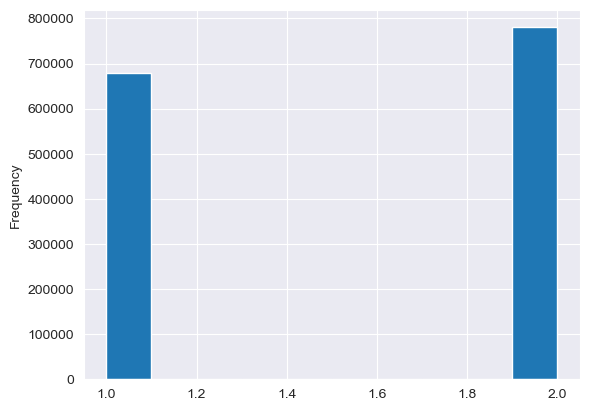

In [192]:
taxi_data_raw['vendor_id'].plot.hist()

## Exploration of pickup_datetime & dropoff_datetime

Objective of the Exploration
- Validate datetime format and logical consistency
- Identify temporal patterns that may affect trip behavior
- Prepare datetime features for modeling and external data joining

Findings
- All timestamps are in ISO-8601 format and correctly parsed as datetime objects
- No negative trip durations found; dropoff times are always after pickup
- Daily pickup/dropoff counts show consistent activity across the dataset
- Clear hourly pickup pattern: peak between 18:00–22:00, trough from 01:00–06:00
- Weekly pattern: peak on Fridays, trough on Sundays
- Monthly pattern: most rides in March, fewest in January
- Some duplicated timestamps exist; may indicate batch logging or system artifacts
- Average trip duration varies by pickup hour, aligning with rush hour traffic behavior

- Required Arrangements
- Recommend extracting and keeping features like pickup_hour, dayofweek, month, hourofyear
- These features support downstream modeling and alignment with weather data

pickup_datetime

In [193]:
taxi_data_raw['pickup_datetime'] = pd.to_datetime(taxi_data_raw['pickup_datetime'])

In [194]:
taxi_data_raw['pickup_datetime'].astype(str).str.match(
    r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$').all()

np.True_

In [195]:
taxi_data_raw['pickup_datetime'].describe()

count                          1458644
mean     2016-04-01 10:10:24.940037120
min                2016-01-01 00:00:17
25%      2016-02-17 16:46:04.249999872
50%                2016-04-01 17:19:40
75%      2016-05-15 03:56:08.750000128
max                2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

dropoff_datetime

In [196]:
taxi_data_raw['dropoff_datetime'] = pd.to_datetime(taxi_data_raw['dropoff_datetime'])

In [197]:
taxi_data_raw['dropoff_datetime'].astype(str).str.match(
    r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$').all()

np.True_

In [198]:
taxi_data_raw['dropoff_datetime'].describe()

count                          1458644
mean     2016-04-01 10:26:24.432310528
min                2016-01-01 00:03:31
25%         2016-02-17 17:05:32.500000
50%                2016-04-01 17:35:12
75%      2016-05-15 04:10:51.750000128
max                2016-07-01 23:02:03
Name: dropoff_datetime, dtype: object

In [199]:
(taxi_data_raw['dropoff_datetime'] < taxi_data_raw['pickup_datetime']).sum()

np.int64(0)

- no negative durations

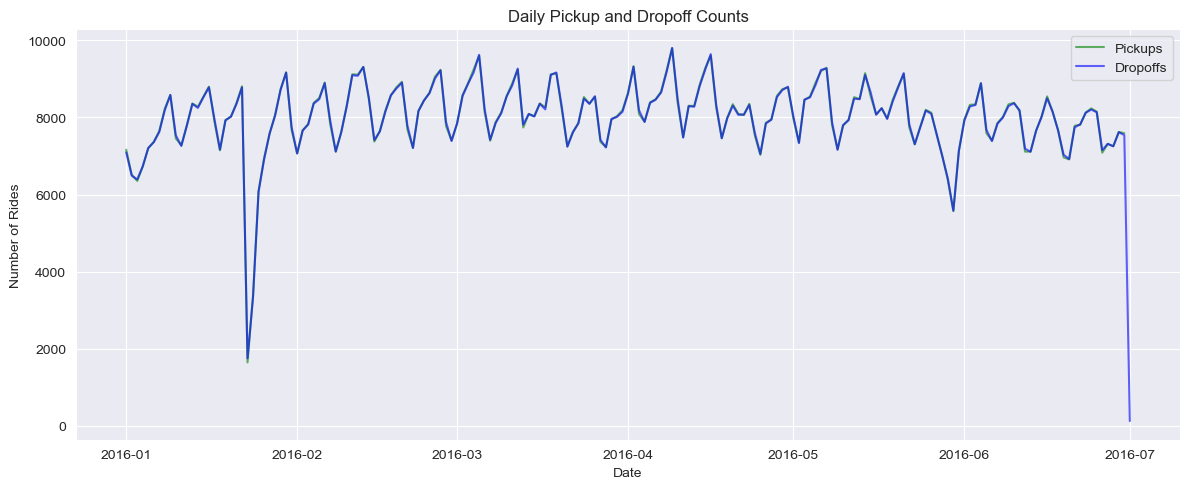

In [200]:
pickup_counts = taxi_data_raw['pickup_datetime'].dt.date.value_counts().sort_index()
dropoff_counts = taxi_data_raw['dropoff_datetime'].dt.date.value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
pickup_counts.plot(ax=ax, label="Pickups", color='green', alpha=0.6)
dropoff_counts.plot(ax=ax, label="Dropoffs", color='blue', alpha=0.6)

ax.set_title("Daily Pickup and Dropoff Counts")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='pickup_datetime'>

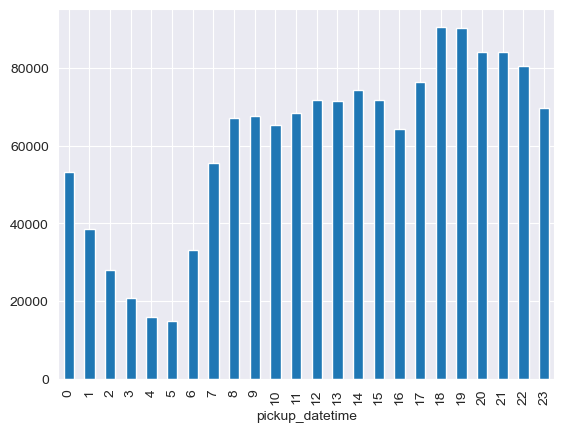

In [201]:
taxi_data_raw['pickup_datetime'].dt.hour.value_counts().sort_index().plot(kind='bar')

- peak from 18 to 22
- trough from 1 to 6

<Axes: xlabel='pickup_datetime'>

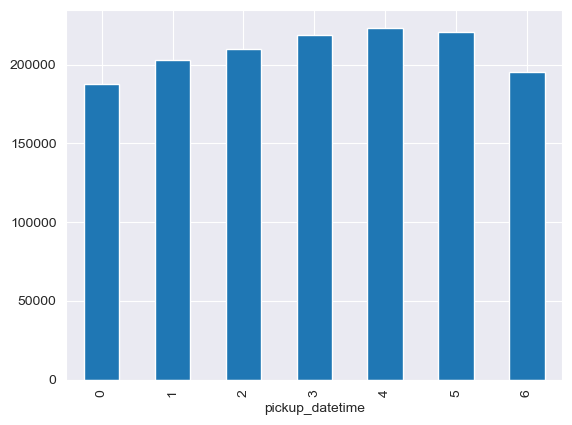

In [202]:
taxi_data_raw['pickup_datetime'].dt.dayofweek.value_counts().sort_index().plot(kind='bar')

In [203]:
taxi_data_raw['pickup_datetime'].dt.dayofweek.value_counts().sort_index()

pickup_datetime
0    187418
1    202749
2    210136
3    218574
4    223533
5    220868
6    195366
Name: count, dtype: int64

- trough on Sunday
- peak on Friday

<Axes: xlabel='pickup_datetime'>

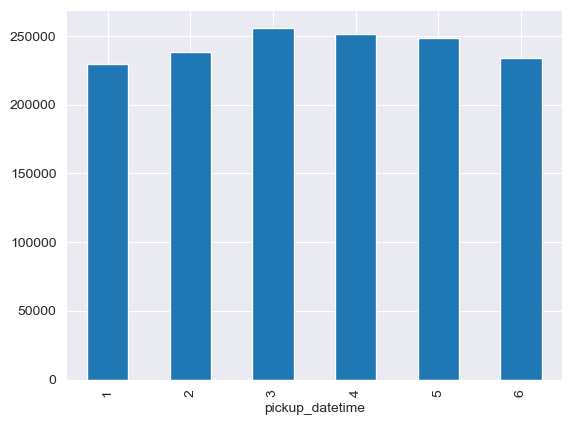

In [204]:
taxi_data_raw['pickup_datetime'].dt.month.value_counts().sort_index().plot(kind='bar')

In [205]:
taxi_data_raw['pickup_datetime'].dt.month.value_counts().sort_index()

pickup_datetime
1    229707
2    238300
3    256189
4    251645
5    248487
6    234316
Name: count, dtype: int64

- trough in January
- peak in March

In [206]:
taxi_data_raw.groupby(['pickup_datetime']).size().sort_values(ascending=False).head()

pickup_datetime
2016-03-04 08:07:34    5
2016-01-12 18:48:44    5
2016-06-10 23:17:17    5
2016-02-09 21:03:38    5
2016-05-07 13:18:07    5
dtype: int64

- could be repeated records

<Axes: xlabel='pickup_datetime'>

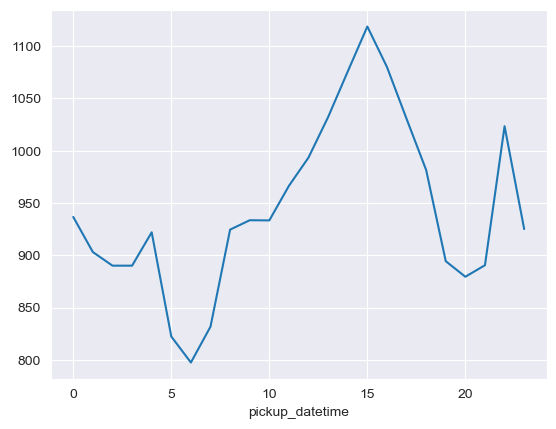

In [207]:
# # shows the average trip duration per pickup hour across a 24-hour day
taxi_data_raw.groupby(taxi_data_raw['pickup_datetime'].dt.hour)['trip_duration'].mean().plot()

- aligns with expected rush hour effects

## Exploration of passenger_count

Objective of the Exploration
- Understand the distribution and validity of passenger counts
- Identify and quantify implausible values (e.g. 0, >6)
- Evaluate whether passenger count influences trip duration

Findings
- The majority of trips have 1 passenger; distribution is heavily right-skewed
- Edge values observed: 60 trips with 0 passengers, and very few with 7–9 passengers
- These edge values are likely invalid or extremely rare
- Trips with 0 passengers show the highest average trip duration, which is implausible and suggests data entry or system error
- Passenger counts 7–9 are extremely rare and may suffer from sampling bias or logging issues
- These edge cases collectively make up a very small share of the data (<0.01%)

Required Arrangements
- Strongly consider removing or flagging trips where `passenger_count` is 0 or greater than 6
- Consider binning `passenger_count` into categories:
  - solo (1)
  - small group (2–4)
  - full load (5–6)
  - unknown/invalid (0, 7–9)
- Keep `passenger_count` as a numeric or categorical feature for modeling
- Use passenger count as an additional signal when filtering unrealistic trip durations or combinations (e.g. 0 passengers with long duration)

In [208]:
taxi_data_raw["passenger_count"].describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

In [209]:
# Passenger count
taxi_data_raw['passenger_count'].value_counts().sort_index()

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: count, dtype: int64

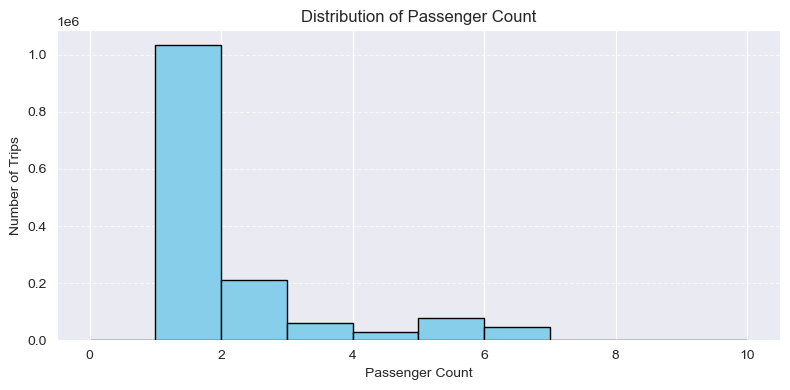

In [210]:
ax = taxi_data_raw['passenger_count'].plot.hist(
    bins=range(0, 11),
    edgecolor='black',
    color='skyblue',
    figsize=(8, 4)
)

ax.set_title("Distribution of Passenger Count")
ax.set_xlabel("Passenger Count")
ax.set_ylabel("Number of Trips")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Axes: xlabel='passenger_count'>

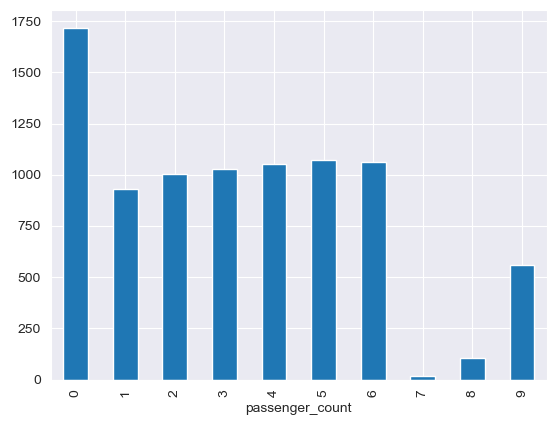

In [211]:
taxi_data_raw.groupby('passenger_count')['trip_duration'].mean().plot(kind='bar')

- Passenger count = 0 has the highest average trip duration, which is not plausible, indicating likely data entry or logging errors

<Axes: xlabel='pickup_datetime'>

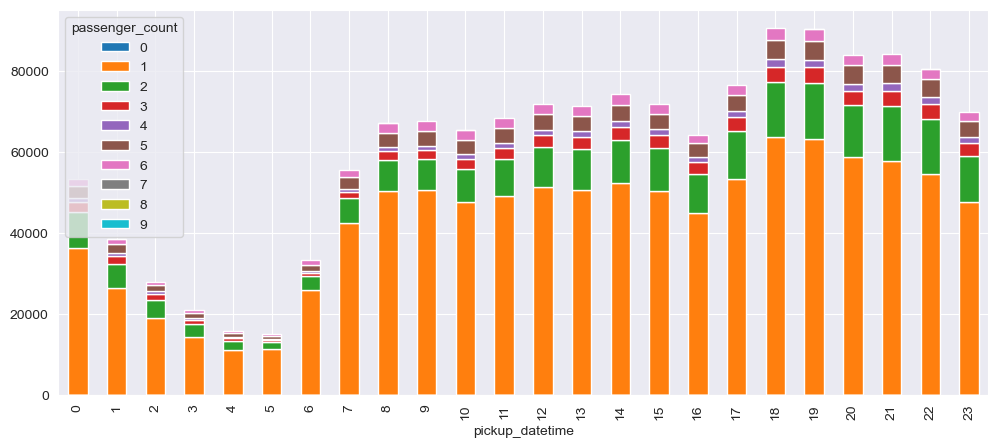

In [212]:
(pd.crosstab(taxi_data_raw['pickup_datetime'].dt.hour, taxi_data_raw['passenger_count']).plot(
  kind='bar', stacked=True, figsize=(12, 5)))

- Passenger count = 1 dominates at all hours
- Group trips (2–4 passengers) are more frequent in the evening and late night

In [213]:
edge_cases = taxi_data_raw['passenger_count'].isin([0, 7, 8, 9])
edge_cases.mean()

np.float64(4.4561935605946344e-05)

- Justify whether to filter or re-label rare values

In [214]:
# View rows with passenger_count == 0
zero_passenger_trips = taxi_data_raw[taxi_data_raw['passenger_count'] == 0]

In [215]:
zero_passenger_trips[['pickup_datetime', 'dropoff_datetime', 'trip_duration']].describe()

,pickup_datetime,dropoff_datetime,trip_duration
count,60,60,60.000000
mean,2016-03-15 22:50:02.650000128,2016-03-15 23:18:41.083333376,1718.433333
min,2016-01-01 05:01:32,2016-01-01 05:01:36,1.000000
25%,2016-02-01 01:11:45.249999872,2016-02-01 01:12:16.750000128,6.750000
50%,2016-03-11 11:06:05.500000,2016-03-11 11:24:22.500000,20.500000
75%,2016-05-06 01:24:55.500000,2016-05-06 01:25:09,92.250000
max,2016-06-13 05:59:07,2016-06-13 05:59:16,85901.000000
std,NaN,NaN,11072.157098


## Explore pickup_longitude, pickup_latitude & dropoff_longitude, dropoff_latitude

Objective of the Exploration
- Validate spatial plausibility of coordinates
- Detect and quantify GPS outliers or errors
- Assess consistency and modeling potential of location features
- Understand the geographic distribution of pickup and dropoff locations.

Findings
- Some trip coordinates lie outside NYC bounds (latitude 40.5–41.0, longitude −74.3 to −73.6)
- While numerically valid, such values are geographically implausible
- Most pickups and dropoffs are located within the NYC area (Manhattan, Brooklyn, Queens).
- Some points lie far outside the visible city bounds — likely due to GPS glitches or data corruption.
- Clear density clusters appear around Midtown and Downtown Manhattan.

Required Arrangements
- Filter trips with pickup/dropoff coordinates outside valid NYC bounding box:
  - Latitude: 40.45 – 41.0
  - Longitude: −74.3 to −73.6
- Consider computing haversine distance as an engineered feature
- Optionally define geographic zones (e.g., airports, boroughs) to support spatial categorization

 N 40.998351 / -73.891735 – O 40.722871 / -73.678676 – S  40.475944 / -74.225408  – W 40.499493 / -74.259239

In [216]:
# Summary statistics for coordinates
taxi_data_raw[
  ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,4.075092e+01,-7.397349e+01,4.075180e+01,-7.397342e+01
std,3.288119e-02,7.090186e-02,3.589056e-02,7.064327e-02
min,3.435970e+01,-1.219333e+02,3.218114e+01,-1.219333e+02
25%,4.073735e+01,-7.399187e+01,4.073588e+01,-7.399133e+01
50%,4.075410e+01,-7.398174e+01,4.075452e+01,-7.397975e+01
75%,4.076836e+01,-7.396733e+01,4.076981e+01,-7.396301e+01
max,5.188108e+01,-6.133553e+01,4.392103e+01,-6.133553e+01


In [217]:
taxi_data_raw[
  (taxi_data_raw['pickup_latitude'] < 40.47) | (taxi_data_raw['pickup_latitude'] > 41.0) |
  (taxi_data_raw['dropoff_latitude'] < 40.47) | (taxi_data_raw['dropoff_latitude'] > 41.0) |
  (taxi_data_raw['pickup_longitude'] < -74.3) | (taxi_data_raw['pickup_longitude'] > -73.6) |
  (taxi_data_raw['dropoff_longitude'] < -74.3) | (taxi_data_raw['dropoff_longitude'] > -73.6)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
115,id2358953,2,2016-06-27 00:31:28,2016-06-27 01:06:44,1,-73.870819,40.773739,-73.857498,41.017811,N,2116
991,id1859156,1,2016-02-17 00:54:13,2016-02-17 01:36:27,3,-73.969254,40.754047,-73.593582,41.043865,N,2534
1101,id3913560,2,2016-01-11 22:48:55,2016-01-11 23:40:20,2,-74.012657,40.702179,-74.307762,40.567341,N,3085
9565,id0304778,1,2016-02-23 20:38:44,2016-02-23 21:19:17,1,-73.982925,40.761841,-74.379631,40.745274,N,2433
13006,id3022813,1,2016-06-15 18:02:41,2016-06-15 18:03:18,1,-73.558289,40.781223,-73.558281,40.781227,N,37
...,...,...,...,...,...,...,...,...,...,...,...
1449228,id2148312,2,2016-04-23 22:44:36,2016-04-23 23:31:57,1,-73.790451,40.646904,-73.837021,41.061226,N,2841
1449384,id3101192,1,2016-05-17 20:43:33,2016-05-17 22:13:12,2,-73.979401,40.752388,-73.872871,41.040192,N,5379
1450700,id1292498,1,2016-06-23 07:02:07,2016-06-23 08:28:12,1,-73.782013,40.644894,-73.774452,41.031044,N,5165
1454301,id1367595,2,2016-04-09 01:38:09,2016-04-09 02:14:52,1,-74.047142,40.789986,-74.010872,41.112366,N,2203


Check Rounding errors

In [218]:
taxi_data_raw['pickup_longitude'].map(lambda x: str(x)[-3:] == '000').mean()

np.float64(0.0)

In [219]:
taxi_data_raw['pickup_latitude'].map(lambda x: str(x)[-3:] == '000').mean()

np.float64(0.0)

In [220]:
taxi_data_raw['dropoff_latitude'].map(lambda x: str(x)[-3:] == '000').mean()

np.float64(0.0)

In [221]:
taxi_data_raw['dropoff_longitude'].map(lambda x: str(x)[-3:] == '000').mean()

np.float64(0.0)

### Geographic distribution

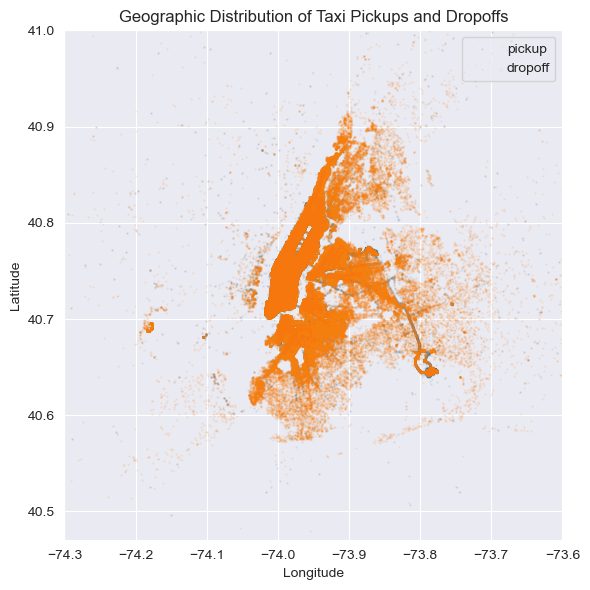

In [222]:
# Scatterplot of pickup and dropoff locations
plt.figure(figsize=(6, 6))
plt.scatter(taxi_data_raw['pickup_longitude'], taxi_data_raw['pickup_latitude'], s=0.5, alpha=0.1,
            label='pickup')
plt.scatter(taxi_data_raw['dropoff_longitude'], taxi_data_raw['dropoff_latitude'], s=0.5, alpha=0.1,
            label='dropoff')
plt.xlim(-74.3, -73.6)
plt.ylim(40.47, 41.0)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')
plt.title("Geographic Distribution of Taxi Pickups and Dropoffs")
plt.grid(True)
plt.tight_layout()
plt.show()

## Explore store_and_fwd_flag

Objective of the Exploration
- Understand the distribution of the categorical variable
- Verify completeness and detect imbalance
- Assess whether it's informative or redundant

Findings
- Two unique values: `N` (No) and `Y` (Yes)
- Majority of trips have flag `N`; only a small fraction are `Y`
- No missing values detected

Required Arrangements
- Retain as categorical variable
- One-hot encoding if used in modeling
- Further multivariate analysis may determine predictive relevance

In [223]:
taxi_data_raw['store_and_fwd_flag'].value_counts(normalize=True)

store_and_fwd_flag
N    0.994485
Y    0.005515
Name: proportion, dtype: float64

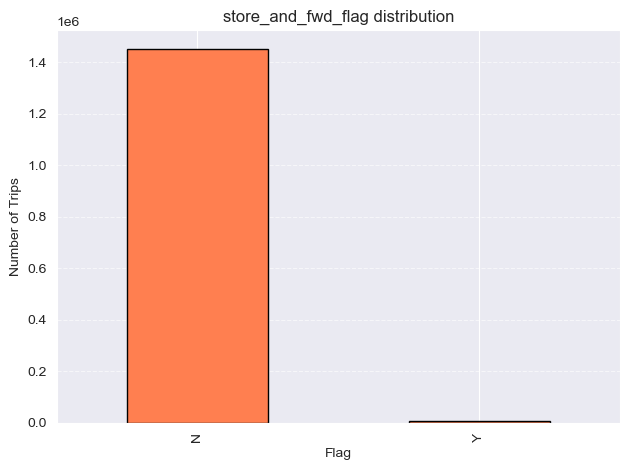

In [224]:
# Frequency count
taxi_data_raw['store_and_fwd_flag'].value_counts(normalize=True)

# Bar plot
taxi_data_raw['store_and_fwd_flag'].value_counts().plot(
    kind='bar', color='coral', edgecolor='black', title="store_and_fwd_flag distribution"
)
plt.ylabel("Number of Trips")
plt.xlabel("Flag")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Exploration of trip_duration

target variable

Findings of the Exploration
- Several trips have a duration longer than 2 hours, which is highly unlikely for intra-city NYC taxi rides. A few trips are also shorter than 1 minute, which may indicate errors or missing data.
- A subset of trips has identical pickup and dropoff locations but long durations, which is potentially a GPS or logging error.

Required Arrangements
- Filter out trips with duration < 1 minute or > 2 hours to remove unrealistic records.

In [225]:
# Summary statistics for trip duration
taxi_data_raw['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [226]:
# Check for extreme trip durations
taxi_data_raw[taxi_data_raw['trip_duration'] > 3 * 3600]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197
...,...,...,...,...,...,...,...,...,...,...,...
1455097,id2798196,2,2016-03-20 03:51:36,2016-03-21 00:00:00,2,-73.969299,40.757301,-73.870277,40.709808,N,72504
1456458,id2055880,2,2016-02-08 19:11:31,2016-02-09 19:08:44,3,-73.973282,40.760792,-73.988518,40.764210,N,86233
1457207,id1910950,2,2016-06-08 16:29:12,2016-06-09 16:11:03,1,-73.958061,40.800869,-73.964119,40.805515,N,85311
1457752,id1215198,2,2016-02-02 11:31:10,2016-02-03 11:29:44,6,-73.972069,40.794220,-73.961014,40.806728,N,86314


In [227]:
taxi_data_raw[taxi_data_raw['trip_duration'] < 60]  # < 1 minute

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
72,id1510700,2,2016-02-20 21:58:13,2016-02-20 21:59:10,1,-73.958397,40.772629,-73.955132,40.774242,N,57
323,id2954399,1,2016-06-27 11:22:37,2016-06-27 11:23:17,1,-74.001030,40.756653,-74.000999,40.756626,N,40
842,id3263580,2,2016-05-21 12:46:46,2016-05-21 12:46:49,2,-73.782372,40.648766,-73.782372,40.648746,N,3
853,id2730154,2,2016-03-29 22:39:46,2016-03-29 22:40:44,5,-73.982201,40.731812,-73.979950,40.734814,N,58
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,N,2
...,...,...,...,...,...,...,...,...,...,...,...
1458044,id3200588,2,2016-03-12 01:35:35,2016-03-12 01:35:42,1,-74.007378,40.739441,-74.007378,40.739449,N,7
1458085,id1326136,2,2016-05-21 12:07:11,2016-05-21 12:07:28,1,-73.978935,40.762463,-73.977654,40.762012,N,17
1458140,id0175875,1,2016-03-22 06:18:10,2016-03-22 06:18:47,1,-73.991325,40.744934,-73.989388,40.748024,N,37
1458544,id3958653,1,2016-06-16 15:10:11,2016-06-16 15:10:49,1,-73.956459,40.767231,-73.956589,40.767269,N,38


<Axes: xlabel='trip_duration'>

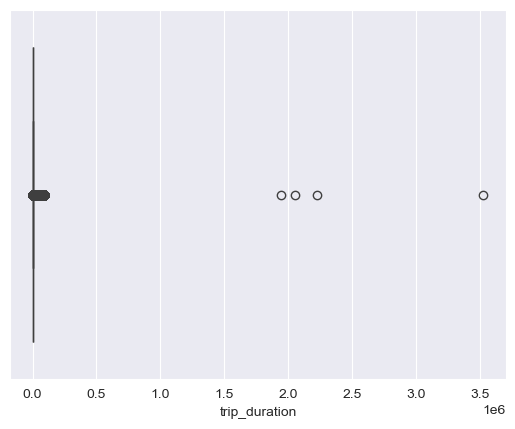

In [228]:
import seaborn as sns
sns.boxplot(x=taxi_data_raw['trip_duration'])

# Feature Engineering 1

## Feature Engineering: vendor_id

Objective:
- Prepare the categorical feature `vendor_id` for use in linear or log-regression models

Findings:
- `vendor_id` contains two values: 1 and 2
- Linear models would incorrectly interpret these as ordered numeric values

Required Arrangements:
- Applied one-hot encoding, resulting in a binary column `vendor_2`
- `vendor_2 = 1` represents original `vendor_id == 2`; `vendor_id == 1` is the baseline
- Drop `vendor_id` for modeling to avoid multicollinearity

In [229]:
# One-hot encode vendor_id for linear/log regression
vendor_dummies = pd.get_dummies(taxi_data_raw['vendor_id'], prefix='vendor', drop_first=True)
taxi_data_raw = pd.concat([taxi_data_raw, vendor_dummies], axis=1)
taxi_data_raw['vendor_2'] = taxi_data_raw['vendor_2'].astype(int)

In [230]:
taxi_data_raw['vendor_2'].dtype

dtype('int64')

- The drop_first=True avoids multicollinearity in linear models by dropping one baseline level.

## Feature Engineering: pickup_datetime

Objective
- Extract meaningful and predictive time-based features from `pickup_datetime`
- Capture temporal patterns such as rush hours, weekdays, and seasonal trends
- Enable alignment with external time-based data (e.g., weather)

Features Extracted
- `pickup_hour`: Hour of day (0–23) — rush hour detection
- `pickup_dayofweek`: Day of week (0 = Monday, ..., 6 = Sunday) — weekday vs. weekend
- `pickup_month`: Calendar month (1–6) — seasonal variations
- `pickup_dayofyear`: Day of year (1–366) — trend and season tracking
- `pickup_hourofyear`: Continuous hour index across the year — used for weather data merging
- `pickup_hour_sin`, `pickup_hour_cos`
- `pickup_dayofweek_sin`, `pickup_dayofweek_cos`
- `pickup_month`
- `pickup_dayofyear`
- `pickup_hourofyear`

Rationale
- These features reflect strong influences on trip behavior, traffic, and duration
- They are all available at the time of pickup, ensuring no data leakage
- sine and cosine encodings to model periodicity.

Required Arrangements
- Keep these features as numeric variables for modeling
- Optionally use cyclical encoding (e.g. sin/cos) for `pickup_hour` and `pickup_dayofweek` if using linear models
- Do not extract features from `dropoff_datetime`, as it's a post-target variable

## Handling Time-Based Features: Raw vs. Cyclical Encoding

Objective
- Decide whether to keep raw time features (`pickup_hour`, `pickup_dayofweek`) or their cyclical encodings (sin/cos) depending on the modeling approach.

**For Linear Models or Neural Networks**
- These models interpret input values as continuous and benefit from recognizing the circular nature of time.

- **Mixed Strategy (Recommended During Exploration)**
- Keep both raw and encoded features during EDA and early modeling.
- Apply model-specific selection or dimensionality reduction during pipeline construction.

In [231]:
import numpy as np

# Time-based features from pickup_datetime
taxi_data_raw['pickup_hour'] = taxi_data_raw['pickup_datetime'].dt.hour
taxi_data_raw['pickup_dayofweek'] = taxi_data_raw['pickup_datetime'].dt.dayofweek  # 0 = Monday
taxi_data_raw['pickup_month'] = taxi_data_raw['pickup_datetime'].dt.month

# For weather join or trend analysis
taxi_data_raw['pickup_dayofyear'] = taxi_data_raw['pickup_datetime'].dt.dayofyear
taxi_data_raw['pickup_hourofyear'] = (taxi_data_raw['pickup_dayofyear'] - 1) * 24 + taxi_data_raw['pickup_hour']

# Cyclical encoding for hour of day
taxi_data_raw['pickup_hour_sin'] = np.sin(2 * np.pi * taxi_data_raw['pickup_hour'] / 24)
taxi_data_raw['pickup_hour_cos'] = np.cos(2 * np.pi * taxi_data_raw['pickup_hour'] / 24)

# Cyclical encoding for day of week
taxi_data_raw['pickup_dayofweek_sin'] = np.sin(2 * np.pi * taxi_data_raw['pickup_dayofweek'] / 7)
taxi_data_raw['pickup_dayofweek_cos'] = np.cos(2 * np.pi * taxi_data_raw['pickup_dayofweek'] / 7)


# Optional for advanced temporal modeling
# taxi_data_raw['pickup_week'] = taxi_data_raw['pickup_datetime'].dt.isocalendar().week
# taxi_data_raw['pickup_quarter'] = taxi_data_raw['pickup_datetime'].dt.quarter

# Multivariat EDA Taxidata

## Explore pickup/dropoff & trip_duration

Findings
- Flag or remove trips where pickup and dropoff locations are (nearly) identical and duration > 5 minutes.

Required Arrangements
- ...


In [ ]:
taxi_data_raw[
  (taxi_data_raw['pickup_latitude'].round(5) == taxi_data_raw['dropoff_latitude'].round(5)) &
  (taxi_data_raw['pickup_longitude'].round(5) == taxi_data_raw['dropoff_longitude'].round(5)) &
  (taxi_data_raw['trip_duration'] > 300)  # more than 5 minutes
  ]

# Feature Engineering Target variable trip_duration

Objective of the Exploration
- Understand the distribution and scale of the target variable trip_duration. Identify skewness,
outliers, and determine whether transformation is necessary for modeling.

In [ ]:
# Trip duration in minutes
taxi_data_raw['trip_duration_min'] = taxi_data_raw['trip_duration'] / 60

In [ ]:
# Histogram (capped at 100 minutes for clarity)
plt.figure(figsize=(8, 4))
plt.hist(taxi_data_raw['trip_duration_min'], bins=100, range=(0, 100), edgecolor='black')
plt.title("Distribution of Trip Duration (minutes)")
plt.xlabel("Trip Duration [min]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Log-transformed trip duration
taxi_data_raw['trip_duration_log'] = np.log1p(taxi_data_raw['trip_duration'])

plt.figure(figsize=(8, 4))
plt.hist(taxi_data_raw['trip_duration_log'], bins=100, edgecolor='black')
plt.title("Log-Transformed Trip Duration")
plt.xlabel("log(1 + trip_duration [s])")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

Log-Transformed Distribution
1. Reduces skewness
The original trip durations are highly skewed: most rides are short, but a few last hours. This heavy right tail can distort models.
The log transformation compresses large values and spreads out small ones, leading to a more balanced distribution.

2. Improves model behavior
Many regression algorithms (like linear regression) assume that the target variable is normally distributed or homoscedastic (constant variance).
The log-transformed duration better fulfills these assumptions.

3. Makes error more meaningful
Model errors in log space correspond to multiplicative errors in the original space. This means:
- predicting 10 minutes instead of 5 (factor 2) is treated the same as 60 instead of 30.

When to avoid it?
- If your model or interpretation needs durations in raw units.
- If your duration already has a narrow, well-behaved range (not the case here).

***

Findings of the Exploration
- The original distribution is strongly right-skewed: most trips last less than 30 minutes, but some exceed 2 hours.
- A log-transformation significantly stabilizes the distribution, making it more suitable for linear models or models assuming normality.
- A few extreme values (very long trips) may distort the mean or variance if unfiltered.


Required Arrangements
- Use the log-transformed trip_duration_log as target variable for regression models.
- Keep trip_duration_min for interpretability and visual analysis.
- Consider capping or removing values >2 hours depending on modeling strategy.


## Extracting time-based features

Objective of the Exploration
- Extract interpretable and useful temporal features from the pickup_datetime to support
seasonality analysis, rush-hour detection, and feature generation for modeling.

In [ ]:
# Basic datetime features
taxi_data_raw['pickup_hour'] = taxi_data_raw['pickup_datetime'].dt.hour
taxi_data_raw['pickup_dayofweek'] = taxi_data_raw['pickup_datetime'].dt.dayofweek  # 0 = Monday
taxi_data_raw['pickup_month'] = taxi_data_raw['pickup_datetime'].dt.month

# Day of year and hour of year (for merging with weather)
taxi_data_raw['pickup_dayofyear'] = taxi_data_raw['pickup_datetime'].dt.dayofyear
taxi_data_raw['pickup_hourofyear'] = (taxi_data_raw['pickup_dayofyear'] - 1) * 24 + taxi_data_raw[
  'pickup_hour']

Findings of the Exploration
- These features capture weekly and daily cycles in traffic (e.g. rush hour, weekday vs. weekend).
- pickup_hourofyear is especially useful for merging with hourly weather data.
- No anomalies found in datetime values; extraction is stable and complete.

Required Arrangements
- Keep these features for modeling as numeric or categorical inputs.
- Optional: encode pickup_dayofweek or pickup_hour cyclically (e.g. using sin/cos) for tree-free models.
- Use pickup_hourofyear for weather-data joins.

In [ ]:
taxi_data_raw

In [ ]:
from numpy import radians, sin, cos, arccos

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    return R * arccos(sin(lat1)*sin(lat2) + cos(lat1)*cos(lat2)*cos(lon2 - lon1))

taxi_data_raw['haversine_km'] = haversine(
    taxi_data_raw['pickup_latitude'], taxi_data_raw['pickup_longitude'],
    taxi_data_raw['dropoff_latitude'], taxi_data_raw['dropoff_longitude']
)

In [ ]:
taxi_data_raw.groupby('store_and_fwd_flag')['trip_duration'].describe()
pd.crosstab(taxi_data_raw['vendor_id'], taxi_data_raw['store_and_fwd_flag'])
taxi_data_raw.plot.scatter(x='haversine_km', y='trip_duration_min', alpha=0.3)
taxi_data_raw.groupby('pickup_hour')['trip_duration_min'].mean().plot()
taxi_data_raw.groupby('passenger_count')['trip_duration_min'].mean().plot(kind='bar')
import seaborn as sns
sns.boxplot(x=taxi_data_raw['trip_duration_min'])
taxi_data_raw.groupby('vendor_id')['trip_duration'].mean()